# Guardar el mejor modelo

Una de las cosas que hemos visto que tenemos que elegir es el número de épocas que entrenamos a nuestro modelo, pero ¿cómo sabemos cuántas épocas entrenar? No tenemos manera de saber cuántas épocas tenemos que entrenar a nuestro modelo, por lo que puede pasar que entrenemos pocas, que lo entrenemos las justas y necesarias (raro) o que lo entrenemos de más y lo sobreentrenemos.

Así que lo que se suele hacer es entrenar un número alto de épocas e ir guardando el mejor modelo para el conjunto de validación, así nos aseguramos de no entrenarlo de menos, y cuando pasen más épocas de las que necesita y comience a sobreentrenarse, tengamos guardado el modelo que dio el mejor resultado en el modelo de validación.

Si lo entrenamos muchas épocas, el error o la métrica en el conjunto de entrenamiento irá bajando, porque lo estamos sobreentrenando, está aprendiéndose el conjunto de entrenamiento. Por eso nos tenemos que quedar con el mejor modelo del conjunto de validación

Ya sabemos cómo entrenar un modelo y también hemos visto como guardarlo. Ahora vamos a ver cómo guardar el mejor modelo posible en el conjunto de validación. Vamos a verlo con el conjunto de datos de cancer

In [1]:
from sklearn import datasets

cancer = datasets.load_breast_cancer()

In [2]:
import pandas as pd

cancer_df = pd.DataFrame(cancer['data'], columns=cancer['feature_names'])
cancer_df['type'] = cancer['target']
cancer_df.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,type
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0


Creamos el dataset

In [3]:
import torch

class CancerDataset(torch.utils.data.Dataset):
    def __init__(self, dataframe):
        cols = [col for col in dataframe.columns if col != 'target']
        self.parameters = torch.from_numpy(dataframe[cols].values).type(torch.float32)
        self.targets = torch.from_numpy(dataframe['type'].values).type(torch.float32)
        self.targets = self.targets.reshape((len(self.targets), 1))

    def __len__(self):
        return len(self.parameters)

    def __getitem__(self, idx):
        parameters = self.parameters[idx]
        target = self.targets[idx]
        return parameters, target

ds = CancerDataset(cancer_df)

train_ds, valid_ds = torch.utils.data.random_split(ds, [int(0.8*len(ds)), len(ds) - int(0.8*len(ds))], generator=torch.Generator().manual_seed(42))
len(train_ds), len(valid_ds)

(455, 114)

Creamos el dataloader

In [4]:
from torch.utils.data import DataLoader

BS_train = 512
BS_val = 128

train_dl = DataLoader(train_ds, batch_size=BS_train, shuffle=True)
val_dl = DataLoader(valid_ds, batch_size=BS_val, shuffle=False)

Creamos la red neuronal

In [5]:
from torch import nn

class CancerNeuralNetwork(nn.Module):
    def __init__(self, num_inputs, num_outputs, hidden_layers=[200, 150, 100, 75, 50, 25, 20]):
        super().__init__()
        self.network = torch.nn.Sequential(
            torch.nn.Linear(num_inputs, hidden_layers[0]),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden_layers[0], hidden_layers[1]),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden_layers[1], hidden_layers[2]),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden_layers[2], hidden_layers[3]),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden_layers[3], hidden_layers[4]),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden_layers[4], hidden_layers[5]),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden_layers[5], hidden_layers[6]),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden_layers[6], num_outputs),
        )
        self.activation = torch.nn.Sigmoid()

    def forward(self, x):
        logits = self.network(x)
        probs = self.activation(logits)
        return logits, probs

num_inputs = 31
num_outputs = 1
model = CancerNeuralNetwork(num_inputs, num_outputs)

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))
model.to(device)

Using cuda device


CancerNeuralNetwork(
  (network): Sequential(
    (0): Linear(in_features=31, out_features=200, bias=True)
    (1): ReLU()
    (2): Linear(in_features=200, out_features=150, bias=True)
    (3): ReLU()
    (4): Linear(in_features=150, out_features=100, bias=True)
    (5): ReLU()
    (6): Linear(in_features=100, out_features=75, bias=True)
    (7): ReLU()
    (8): Linear(in_features=75, out_features=50, bias=True)
    (9): ReLU()
    (10): Linear(in_features=50, out_features=25, bias=True)
    (11): ReLU()
    (12): Linear(in_features=25, out_features=20, bias=True)
    (13): ReLU()
    (14): Linear(in_features=20, out_features=1, bias=True)
  )
  (activation): Sigmoid()
)

Creamos la funcuón de pérdida y el optimizador

In [6]:
LR = 1e-3

loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=LR)

Definimos la función de entrenamiento, volvemos a usar la barra de progreso vista en el tema anterior

Durante el entrenamiento hacemos el bucle de `train` y `val`. Durante la validación medimos 2 cosas, el error (`val_loss`) y la cantidad de datos predichos correctamente (`correct`), este último es nuestra métrica, y es lo que vamos a tener en cuenta para guardar el modelo.

Lo que haremos es que cuando en la época en la que se esté, el modelo prediga más datos correctos que en épocas anteriores guardaremos ese modelo.

In [7]:
import numpy as np

def plot_loss_update(epoch, epochs, mb, train_loss, valid_loss):
    """ dynamically print the loss plot during the training/validation loop.
        expects epoch to start from 1.
    """
    x = range(1, epoch+1)
    y = np.concatenate((train_loss, valid_loss))
    graphs = [[x,train_loss], [x,valid_loss]]
    x_margin = 0.2
    y_margin = 0.05
    x_bounds = [1-x_margin, epochs+x_margin]
    y_bounds = [np.min(y)-y_margin, np.max(y)+y_margin]

    mb.update_graph(graphs, x_bounds, y_bounds)

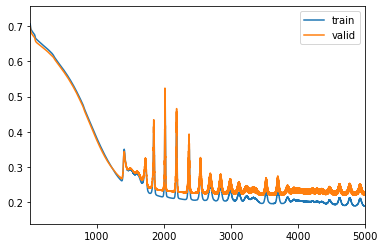

In [8]:
from fastprogress.fastprogress import master_bar, progress_bar
from time import sleep
import os

path_folder = "data/"
# Si el directorio donde se va a guardar el modelo no existe, se crea
if not os.path.isdir(path_folder):
    os.mkdir(path_folder)

epochs = 5000
mb = master_bar(range(1, epochs+1))
train_loss, valid_loss = [], []
correct_metric = 0
for epoch in mb:
    # train loop
    model.train()
    for (X, y) in progress_bar(train_dl, parent=mb):
        # X and y to device
        X, y = X.to(device), y.to(device)

        # Compute prediction and loss
        logits, probs = model(X)
        loss = loss_fn(logits, y)
        mb.child.comment = f'train loss: {loss.item():>7f}'

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    # validation loop
    num_batches = len(val_dl)
    val_loss, correct = 0, 0
    model.eval()
    with torch.no_grad():
        for X, y in progress_bar(val_dl, parent=mb):
            # X and y to device
            X, y = X.to(device), y.to(device)
            
            logits, probs = model(X)
            val_loss += loss_fn(logits, y).item()
            correct += (probs.round() == y).type(torch.float).sum().item()
            mb.child.comment = f'epoch: {epoch}, val loss: {val_loss:>7f}, correct: {int(correct):03d}'

    train_loss.append(loss.item())
    valid_loss.append(val_loss)
    mb.main_bar.comment = f'epoch: {epoch}/{epochs}, train loss: {train_loss[-1]:>7f}, valid loss: {valid_loss[-1]:>7f}'
    if int(correct) > correct_metric:
        best_model_name = f'best_model_epoch_{epoch}.zip'
        model_path = path_folder + best_model_name
        correct_metric = int(correct)
        # Remove the previous best model
        for f in os.listdir(path_folder):
            os.remove(os.path.join(path_folder, f))
        # Save model
        torch.jit.save(torch.jit.script(model), model_path)
        mb.write(f'epoch: {epoch}, train loss: {train_loss[-1]:>7f}, valid loss: {valid_loss[-1]:>7f}, correct: {int(correct):>3d}, best model')

    plot_loss_update(epoch, epochs, mb, train_loss, valid_loss)

Como se puede ver nos hemos quedado con el mejor modelo de una de las épocas del inicio